In [1]:
from phasic_tonic.detect_phasic import detect_phasic_v2
from phasic_tonic.helper import get_metadata
from phasic_tonic.runtime_logger import logger_setup
from phasic_tonic.utils import get_sequences, get_segments

import numpy as np
import pandas as pd
import pynapple as nap

from pathlib import Path
from tqdm.auto import tqdm
from scipy.io import loadmat

fs = 500

logger = logger_setup()

CONFIG_DIR = "/home/nero/phasic_tonic/data/dataset_loading.yaml"
DATASET_DIR = "/home/nero/datasets/preprocessed"
OUTPUT_DIR1 = "/home/nero/phasic_tonic/data/analysis_output/whole_posttrial5/"
OUTPUT_DIR2 = "/home/nero/phasic_tonic/data/analysis_output/segmented_posttrial5/"

def str_to_tuple(string):
    string = string.strip("()")
    parts = string.split(",")
    return tuple(map(int, parts))

def load_data(fname):
    loaded_data = np.load(fname)
    loaded_dict = {str_to_tuple(key): loaded_data[key] for key in loaded_data.files}
    return loaded_dict

compressed_datasets = list(Path(DATASET_DIR).glob('*.npz'))

len(compressed_datasets)

699

In [2]:
def compute_stats(rem_interval, phasic_interval, tonic_interval) -> pd.DataFrame:
        """
        Compute statistics for phasic and tonic REM periods.

        Returns
        -------
        pd.DataFrame
            DataFrame containing computed statistics.
        """
        stats = {
            "rem_start": [], "rem_end": [], "state": [],
            "num_bouts": [], "mean_duration": [],
            "total_duration": [], "percent_of_rem": []
        }

        for rem_idx in rem_interval:
            phasic = rem_idx.intersect(phasic_interval)
            tonic = rem_idx.intersect(tonic_interval)

            for state, intervals in [("phasic", phasic), ("tonic", tonic)]:
                _compute_interval_stats(rem_idx, state, intervals, stats)

        return pd.DataFrame(stats)

def _compute_interval_stats(rem_idx, state, intervals, stats):
    """
    Compute statistics for a given interval.
    """
    num_bouts = len(intervals)
    durations = np.diff(intervals, 1)
    total_duration = np.sum(durations)
    percent_of_rem = total_duration / rem_idx.tot_length()

    stats["rem_start"].append(int(rem_idx["start"].item()))
    stats["rem_end"].append(int(rem_idx["end"].item()))
    stats["state"].append(state)
    stats["num_bouts"].append(num_bouts)
    stats["mean_duration"].append(durations.mean())
    stats["total_duration"].append(total_duration)
    stats["percent_of_rem"].append(percent_of_rem)

In [35]:
per_trial_stats = {
    'rat_id': [],
    'study_day': [],
    'condition': [],
    'treatment': [],
    'trial_num': [],
    'state' : [],
    'num_bouts': [],
    'total_duration' : []
}

with tqdm(compressed_datasets) as datasets:
    for fname in datasets:
        metaname = str(fname.stem)

        datasets.set_postfix_str(metaname)
        metadata = get_metadata(metaname)

        rem_epochs = load_data(fname)

        if not rem_epochs:
            continue
        
        phrem = detect_phasic_v2(rem_epochs, fs)
        
        start, end = [], []
        rem_start, rem_end = [], []
        for rem_idx in phrem:
            rem_start.append(rem_idx[0])
            rem_end.append(rem_idx[1])

            for s, e in phrem[rem_idx]:
                start.append(s / fs)
                end.append(e / fs)
        
        rem_interval = nap.IntervalSet(rem_start, rem_end)
        phasic_interval = nap.IntervalSet(start, end)
        tonic_interval = rem_interval.set_diff(phasic_interval)

        if metadata['trial_num'] in ['5-0', '5-1', '5-2', '5-3']:
            a, b = metadata['trial_num'].split('-')
            metadata['trial_num'] = a + '.' + str(int(b)+1)
        
        # Save duration bouts
        for state, interval in [("phasic", phasic_interval), ("tonic", tonic_interval)]:
            for condition in metadata.keys():
                per_trial_stats[condition].append(metadata[condition])
            per_trial_stats['state'].append(state)
            per_trial_stats['total_duration'].append(interval.tot_length())
            per_trial_stats['num_bouts'].append(len(interval))

df_trial = pd.DataFrame(per_trial_stats)

  0%|          | 0/699 [00:00<?, ?it/s]

In [36]:
df_trial

,rat_id,study_day,condition,treatment,trial_num,state,num_bouts,total_duration
0,2,2,OR,2,5.4,phasic,4,6.624
1,2,2,OR,2,5.4,tonic,7,160.376
2,4,4,HC,3,4,phasic,0,0.000
3,4,4,HC,3,4,tonic,3,46.000
4,3,4,OD,4,2,phasic,1,1.270
...,...,...,...,...,...,...,...,...
1269,1,1,OD,4,5.3,tonic,9,252.202
1270,5,3,OD,0,5.1,phasic,2,3.134
1271,5,3,OD,0,5.1,tonic,3,73.866
1272,6,4,CON,4,3,phasic,2,6.636


<Axes: xlabel='trial_num', ylabel='total_duration'>

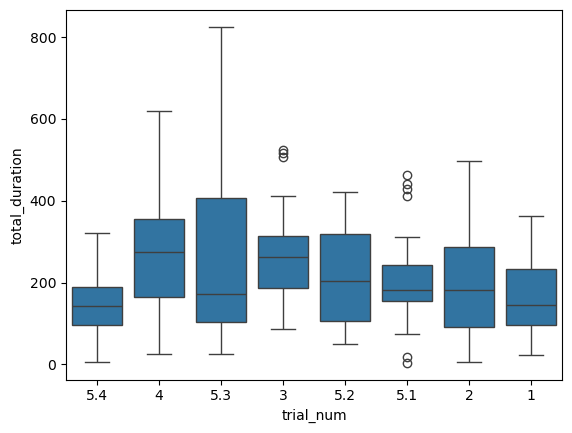

In [55]:
import seaborn as sns

rgs = df_trial[(df_trial['treatment']==2) | (df_trial['treatment']==3)]
sns.boxplot(data=rgs[rgs['state']=='tonic'], x='trial_num', y='total_duration')

In [37]:
df_trial.to_csv(OUTPUT_DIR2+"phasic_tonic_per_trials.csv", index=False)